# Build Datasets: ML & CV Orchestrator

Run from the **project root**. It uses your `scripts/` modules to generate:
- ML features and labels parquet datasets
- Optional CV image renders for visual QA

Edit parameters in the next cell and execute top-to-bottom.


In [1]:
# Рабочий каталог = корень проекта
import os, sys, pathlib
ROOT = pathlib.Path(r"C:\Users\Admin\Desktop\Code\Trade-bot")  # подправь путь при необходимости
os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

# Авто-перезагрузка модулей при правках
%load_ext autoreload
%autoreload 2

import platform, pandas as pd
print("CWD:", pathlib.Path().resolve())
print("Python:", platform.python_version())


CWD: C:\Users\Admin\Desktop\Code\Trade-bot
Python: 3.11.0


In [20]:
TICKER     = "SBER"
TF         = "1d"                  # "1m" / "5m" / "1h" / "1d"
START      = "2024-10-04"
END        = "2025-10-04"
FIGI       = "BBG004730N88"        # FIGI SBER (пример)
YF_SYMBOL  = "SBER.ME"             # запасной символ для yfinance

RAW_GLOB   = f"data/raw/*/{TICKER}/{TF}/year=*/month=*/part.parquet"
FEAT_PATH  = f"data/features/ml/{TICKER}/{TF}/features.parquet"
FEAT_LBL   = f"data/features/ml/{TICKER}/{TF}/features_labeled.parquet"


In [21]:
from scripts import fetch_data as F
import pandas as pd

# В модуле могло не быть fetch_intraday — добавим тонкую обёртку тут
def fetch_intraday(ticker: str, tf: str, start, end, figi: str|None=None, yf_symbol: str|None=None):
    if hasattr(F, "fetch_intraday"):
        return F.fetch_intraday(ticker, tf, start, end, figi, yf_symbol)
    # Иначе используем функции из модуля (Tinkoff -> MOEX -> yfinance)
    from datetime import datetime
    def _dt(x): 
        return x if isinstance(x, datetime) else datetime.fromisoformat(str(x))
    START, END = _dt(start), _dt(end)
    try:
        if figi:
            dft = F.fetch_tinkoff_chunked(figi, tf, START, END)
            if not dft.empty:
                return dft.sort_values("time").drop_duplicates("time"), "tinkoff"
    except Exception: 
        pass
    try:
        dfm = F.fetch_moex_history(ticker, tf, str(START.date()), str(END.date()))
        if not dfm.empty:
            return dfm.sort_values("time").drop_duplicates("time"), "moex"
    except Exception:
        pass
    sym = yf_symbol or f"{ticker}.ME"
    dfy = F.fetch_yf(sym, tf, str(START.date()))
    if not dfy.empty:
        return dfy.sort_values("time").drop_duplicates("time"), "yfinance"
    return pd.DataFrame(), None

df_raw, src = fetch_intraday(TICKER, TF, START, END, figi=FIGI, yf_symbol=YF_SYMBOL)
print("source:", src, "rows:", len(df_raw), df_raw["time"].min() if len(df_raw) else None, "→", df_raw["time"].max() if len(df_raw) else None)
df_raw.head()


source: tinkoff rows: 302 2024-10-04 00:00:00+00:00 → 2025-10-04 00:00:00+00:00


,time,open,high,low,close,volume
0,2024-10-04 00:00:00+00:00,264.96,265.44,262.11,264.09,25992290
1,2024-10-07 00:00:00+00:00,264.25,267.00,261.37,263.39,28940600
2,2024-10-08 00:00:00+00:00,263.00,263.80,261.89,262.40,16163780
3,2024-10-09 00:00:00+00:00,262.42,263.80,259.59,260.86,25021350
4,2024-10-10 00:00:00+00:00,260.88,261.64,258.91,259.98,17677230


In [22]:
if not df_raw.empty:
    F.save_partitioned(df_raw, source=src or "tinkoff", ticker=TICKER, tf=TF)


In [23]:
from scripts.make_intraday_features import build_features
import os
os.makedirs(os.path.dirname(FEAT_PATH), exist_ok=True)

fe = build_features(RAW_GLOB)
fe.to_parquet(FEAT_PATH, index=False)
len(fe), FEAT_PATH


(302, 'data/features/ml/SBER/1d/features.parquet')

In [24]:
from scripts.make_labels import next_k_return, triple_barrier
df = pd.read_parquet(FEAT_PATH).sort_values("time")

df = next_k_return(df, k=5)                 # добавит ret_fwd_5
df = triple_barrier(df, k=20, up=0.004, dn=0.004)  # добавит y_tb_20

df.to_parquet(FEAT_LBL, index=False)
len(df), df.columns.tolist()[-6:], FEAT_LBL


(302,
 ['date', 'bar_id', 'is_open_30', 'is_close_30', 'ret_fwd_5', 'y_tb_20'],
 'data/features/ml/SBER/1d/features_labeled.parquet')

In [25]:
from scripts.render_cv_images import render_with_manifest
MANIFEST = f"data/cv/images/{TICKER}/{TF}/win64_step16/manifest_with_vol.csv"

rows = render_with_manifest(
    in_parquet = FEAT_LBL,
    ticker     = TICKER,
    tf         = TF,
    size       = 64,
    step       = 16,
    horizon    = 5,
    show_axes  = False,          # True для дебага с осями
    show_volume= True,           # рисуем колонны объёма
    vol_mode   = "raw",          # 'raw' | 'zscore' | 'rel'
    fixed_ylim = "window",       # автоскейл по окну для цен
    manifest_csv = MANIFEST
)
len(rows), MANIFEST


(15, 'data/cv/images/SBER/1d/win64_step16/manifest_with_vol.csv')

In [26]:
from scripts.qc_report import qc_summary
qc = qc_summary(RAW_GLOB)
qc


,rows,zero_price,bad_hl,zero_vol,max_gap
0,302,0,0,0,4 days 00:00:00


In [27]:
import glob
files = glob.glob(f"data/features/ml/{TICKER}/{TF}/*.parquet")
mart = (pd.concat((pd.read_parquet(p) for p in files), ignore_index=True)
          .drop_duplicates("time").sort_values("time"))
os.makedirs("warehouse", exist_ok=True)
MART_FILE = f"warehouse/{TICKER.lower()}_{TF}.parquet"
mart.to_parquet(MART_FILE, index=False)
len(mart), MART_FILE


(302, 'warehouse/sber_1d.parquet')

In [28]:
pd.read_parquet(FEAT_LBL).tail()


,time,open,high,low,close,volume,ret_1,ret_5,rng_1,vol_20,vwap_20,dist_vwap,date,bar_id,is_open_30,is_close_30,ret_fwd_5,y_tb_20
297,2025-09-30 00:00:00+00:00,287.67,289.88,285.24,288.36,29382368,0.002743,-0.005326,0.016135,0.009420,298.475711,-0.035080,2025-09-30,0,1,1,-0.087920,-1
298,2025-10-01 00:00:00+00:00,288.88,290.39,285.11,286.40,22897705,-0.006820,-0.017067,0.018310,0.009369,297.451163,-0.038586,2025-10-01,0,1,1,-0.083754,-1
299,2025-10-02 00:00:00+00:00,286.40,287.15,282.80,285.22,28023440,-0.004129,-0.022431,0.015189,0.009256,296.243134,-0.038648,2025-10-02,0,1,1,-0.083391,-1
300,2025-10-03 00:00:00+00:00,285.75,287.32,282.58,282.91,17098575,-0.008132,-0.028469,0.016619,0.009245,295.121846,-0.043165,2025-10-03,0,1,1,-0.081145,-1
301,2025-10-04 00:00:00+00:00,283.00,283.00,279.39,280.40,5632692,-0.008912,-0.025249,0.012760,0.009140,294.099232,-0.048856,2025-10-04,0,1,1,-0.075612,0


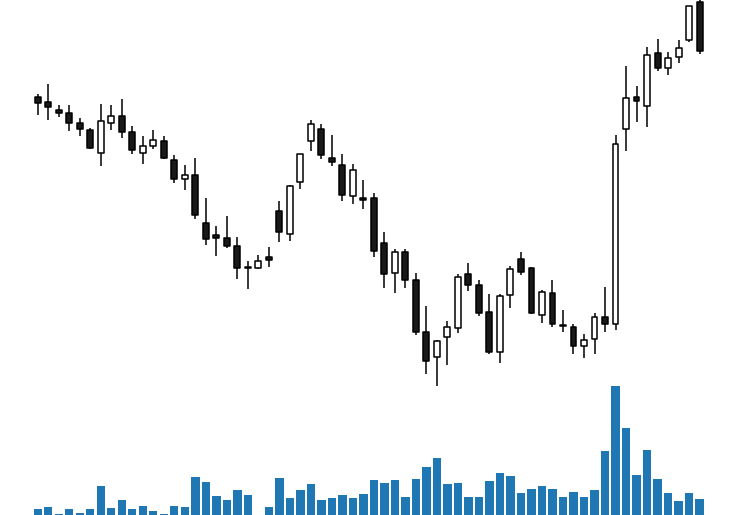

In [29]:
# показать одну сгенерированную картинку
from IPython.display import Image, display
import glob
imgs = glob.glob(f"data/cv/images/{TICKER}/{TF}/win64_step16/*/img_*.png")
display(Image(filename=imgs[0])) if imgs else print("Нет изображений.")


In [32]:
# Monte-Carlo valuation: FV/PV, mispricing metrics
import numpy as np, pandas as pd
from dataclasses import dataclass

# --- вход: путь к файлу с ценами (достаточно колонок time, close) ---
PATH = "warehouse/sber_1m.parquet"  # можно заменить на daily файл с колонками time, close
TICKER = "SBER"

# --- параметры моделирования ---
HORIZON_DAYS = 20             # горизонт прогноза в торговых днях
N_SIMS       = 20000          # число симуляций
MODEL        = "gbm"          # "gbm" или "bootstrap" (эмпирическое бутстрапирование дневных ретёрнов)
DT           = 1/252          # шаг (в годах) для дневной сетки
R_ANNUAL     = 0.12           # годовая ставка дисконтирования (напр., рубл. безрисковая/требуемая доходность)
USE_LOG      = True           # PV/FV считаем из лог-нормальной цены
SEED         = 42

# --- подготовка дневных ретёрнов из произвольной частоты ---
df = pd.read_parquet(PATH).sort_values("time").copy()
df["time"] = pd.to_datetime(df["time"])
# если это минутки — агрегируем в дневные "close" по последнему бару
daily = (df.set_index("time")[["close"]]
           .resample("1D").last()
           .dropna().rename(columns={"close":"close"}))

# фильтр по торговым дням (исключим дни без движения, если были)
daily = daily.replace([np.inf, -np.inf], np.nan).dropna()
px = daily["close"].astype(float)
r  = np.log(px).diff().dropna() if USE_LOG else px.pct_change().dropna()

# --- калибровка параметров GBM ---
mu_hat  = r.mean() * 252      # годовой дрейф по историческим данным
sig_hat = r.std(ddof=1) * np.sqrt(252)  # годовая волатильность

@dataclass
class MCResult:
    fv_stats: pd.DataFrame
    pv_stats: pd.DataFrame
    details: dict

np.random.seed(SEED)
S0 = float(px.iloc[-1])

def mc_simulate(S0, horizon_days, n_sims, model="gbm"):
    steps = horizon_days
    if model == "gbm":
        # дневная дискретизация GBM
        mu_d  = mu_hat / 252.0
        sig_d = sig_hat / np.sqrt(252.0)
        # S_T = S0 * exp(sum((mu - 0.5*sigma^2)*dt + sigma*sqrt(dt)*Z))
        z = np.random.normal(size=(steps, n_sims))
        increments = (mu_d - 0.5*sig_d**2) + sig_d * z  # dt=1 день
        log_ST = np.log(S0) + increments.sum(axis=0)
        ST = np.exp(log_ST)
    elif model == "bootstrap":
        # эмпирическое бутстрапирование дневных ретов
        boot_r = np.random.choice(r.values, size=(steps, n_sims), replace=True)
        if USE_LOG:
            ST = S0 * np.exp(boot_r.sum(axis=0))
        else:
            ST = S0 * np.prod(1 + boot_r, axis=0)
    else:
        raise ValueError("Unknown model")
    return ST

# --- считaем распределения FV и PV ---
ST = mc_simulate(S0, HORIZON_DAYS, N_SIMS, MODEL)
# FV = ST (будущая стоимость на горизонте)
FV = ST
# PV = ожидаемая будущая стоимость, дисконтированная в "сегодня"
disc = np.exp(-R_ANNUAL * (HORIZON_DAYS/252.0))
PV  = FV * disc

def summarize(vec):
    return pd.Series({
        "mean": np.mean(vec),
        "median": np.median(vec),
        "p05": np.percentile(vec, 5),
        "p25": np.percentile(vec, 25),
        "p75": np.percentile(vec, 75),
        "p95": np.percentile(vec, 95),
        "std": np.std(vec, ddof=1)
    })

fv_stats = summarize(FV)
pv_stats = summarize(PV)

# --- метрики "переоценен/недооценен" ---
cur = S0
# вероятность, что дисконтированная стоимость > текущей цены
p_pv_gt_spot = float((PV > cur).mean())
# ожидаемая доходность к горизонту (реальная, не дисконт.)
exp_ret = float((FV/cur - 1.0).mean())
# миспрайсинг как отношение справедливой PV к споту
pv_fair = pv_stats["mean"]
mispricing_ratio = float(pv_fair / cur)   # >1 недооценен, <1 переоценен
# z-score текущей цены относительно PV-распределения
pv_std = pv_stats["std"]
pv_z = float((cur - pv_fair) / pv_std) if pv_std > 0 else np.nan
# вероятность убытка на горизонте
p_loss = float((FV < cur).mean())
# ожидаемый shortfall при 5% (ES)
q05 = np.percentile(FV, 5)
es05 = float(FV[FV <= q05].mean()) if (FV <= q05).any() else np.nan

report = pd.DataFrame({
    "ticker": [TICKER],
    "model": [MODEL],
    "S0": [cur],
    "H_days": [HORIZON_DAYS],
    "r_annual": [R_ANNUAL],
    "mu_ann_hist": [mu_hat],
    "sigma_ann_hist": [sig_hat],
    "PV_mean": [pv_fair],
    "PV/Spot": [mispricing_ratio],
    "PV_z": [pv_z],
    "P(PV>Spot)": [p_pv_gt_spot],
    "E[Ret]": [exp_ret],
    "P(Loss)": [p_loss],
    "ES_5pct": [es05],
    "FV_p05": [np.percentile(FV,5)],
    "FV_p50": [np.percentile(FV,50)],
    "FV_p95": [np.percentile(FV,95)]
})

print("=== FV stats ==="); display(fv_stats.to_frame("value"))
print("=== PV stats ==="); display(pv_stats.to_frame("value"))
print("=== Valuation report ==="); display(report)


=== FV stats ===


,value
mean,264.940248
median,264.751366
p05,247.764723
p25,257.639629
p75,271.929752
p95,282.671504
std,10.603861


=== PV stats ===


,value
mean,262.428985
median,262.241893
p05,245.416260
p25,255.197565
p75,269.352239
p95,279.992174
std,10.503352


=== Valuation report ===


,ticker,model,S0,H_days,r_annual,mu_ann_hist,sigma_ann_hist,PV_mean,PV/Spot,PV_z,P(PV>Spot),E[Ret],P(Loss),ES_5pct,FV_p05,FV_p50,FV_p95
0,SBER,gbm,282.91,20,0.12,-0.826943,0.142733,262.428985,0.927606,1.94995,0.0283,-0.063518,0.9522,243.728579,247.764723,264.751366,282.671504
